In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
import glob
import time
import pickle

In [2]:
# HYPERPARAMETERS

# Hog features
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel=1
classifier_shape = (64,64) # Defines the image shape required for the classifier




y_start = 390
y_stop = 610
input_image_shape_x = 1280
y_window_gap = 20 # Pixel gap between windows in y direction
x_num_windows = 20 # Number of frames which will be distributed along the x-axis on one y level

y_window_h_min = 30 # Number of pixels for the minimum window hight of the top frame (must not be larger than 2* 
                    # y_window_gap)

window_ratio = 1.5 # window ratio * window hight = window width



# 1 Create detection classifier (Histogram of Oriented Gradients (HOG))

## 1.1 Initialize images and labels

In [3]:
# Load images
try:
    with open("X_images.p","wb") as X_features:
        X = pickle.load(X_features)
    with open("y_labels.p","wb") as y_labels:
        y = pickle.load(y_labels)
    print("Images were loaded from pickle file")

except:
    imgs_vehicle = glob.glob('labeled_data/vehicles/*/*.png')
    imgs_non_vehicle = glob.glob('labeled_data/non-vehicles/*/*.png')

    # Define y values
    y = np.concatenate((np.ones(len(imgs_vehicle)),np.zeros(len(imgs_non_vehicle))))

    X_veh = [mpimg.imread(image_path) for image_path in imgs_vehicle]
    X_n_veh = [mpimg.imread(image_path) for image_path in imgs_non_vehicle]

    X = np.concatenate((X_veh,X_n_veh))
    
    with open("X_images.p","wb") as X_features:
        pickle.dump(X, X_features)
    with open("y_labels.p","wb") as y_labels:
        pickle.dump(y,y_labels)
        
        
print("Shape of feature array:\t{}\nShape of label array:\t{}".format(X.shape,y.shape))

Shape of feature array:	(17760, 64, 64, 3)
Shape of label array:	(17760,)


In [4]:
# Shuffle images
X,y = shuffle(X,y)

## 1.2 Extract image features

In [5]:
# Define a function to extract hog-features from a list of images
def extract_features(imgs, orient, pix_per_cell, cell_per_block, hog_channel, classifier_shape):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        img = cv2.resize(img,dsize=classifier_shape)/255
        hog_features = hog(img[:,:,hog_channel], orientations=orient,
                                        pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                        cells_per_block=(cell_per_block, cell_per_block), 
                                        transform_sqrt=True, visualise=False, feature_vector=True)
            
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [6]:
# Extract features
try:
    with open("X_features.p","rb") as X_feat:
        X_features = pickle.load(X_feat)
    print("Features were loaded from pickle file")
except:
    X_features = extract_features(X,orient, pix_per_cell, cell_per_block, hog_channel,classifier_shape)
    with open("X_features.p","wb") as X_feat:
        pickle.dump(X, X_feat)

## 1.3 Initialize training and testing data

In [7]:
# Perform split in train and test data
X_train, X_test, y_train, y_test = train_test_split (X_features,y,test_size = 0.2)

## 1.4 Fit and test classifier (SVM)

In [8]:
# Create classifier

try:
    # Try to load classifier from pickle (if fitted earlier)
    with open("classifier.p","rb") as cls:
        svc = pickle.load(cls)
    print("Classifier were loaded from pickel file.")
    
except:

    # Define SVM classifier
    svc = LinearSVC()

    # Fit classifier
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print("Seconds to train classifier:\t{:.2f}".format(t2-t1))
    
    # Dump classifier in pickle file
    with open("classifier.p","wb") as cls:
        pickle.dump(svc,cls)

Seconds to train classifier:	3.55


In [9]:
# Evaluate classifier
accuracy = svc.score(X_test, y_test)
print("Accuracy of current classifier:\t{:.4f}".format(accuracy))

Accuracy of current classifier:	0.9693


In [12]:
imgs_test_case = glob.glob('labeled_data/vehicles/GTI_Far/*.png')
X_test_case = [mpimg.imread(image_path) for image_path in imgs_test_case]
X_test_features = extract_features(X_test_case,orient, pix_per_cell, cell_per_block, 
                                   hog_channel,classifier_shape)

In [13]:
test_predict = svc.predict(X_test_features)

print(test_predict[:100])

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


# 2 Sliding Window Search

## 2.1 Define windows

In [85]:
# Read in test images

# Get all test image names
test_img_names = sorted(glob.glob('test_images/*.jpg'))

# Load test images into np.array
test_imgs = np.array([mpimg.imread(name) for name in test_img_names])
    
print("Shape of test image array:\n{}".format(test_imgs.shape))

Shape of test image array:
(6, 720, 1280, 3)


In [15]:
def plot_and_save_test_imgs(img, y_start,y_stop, rectangle = False, point_1 = None, point_2 = None, 
                            img_save = False, save_path = None):
    """
    Enables display, adding of rectangled windows and saving of test images
    
    Input:
    img (np.array): Test image to be plotted, (rectangled and saved). E.g. 'test_imgs[0]'
    y_start (int): Starting pixel value of the new image in input image terms
    y_stop (int): Ending pixel value of the new image in input image terms
    rectangle (bool): Indicates, whether rectangle should be displayed on image
    point_1 (tuple): First corner point for the rectangle
    point_2 (tuple): Second corner point for the rectangle
    img_save (bool): Indicates, whether image should be saved
    save_path (str): Path for saving
    """
    img_plt = np.copy(img[y_start:y_stop,:,:])
    if rectangle:
        cv2.rectangle(img_plt, point_1, point_2,(0,0,255),6)
    plt.imshow(img_plt)
    plt.axis("off")
    if img_save:
        plt.imsave(save_path,img_plt)

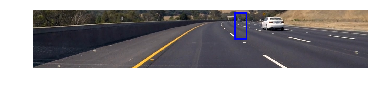

In [16]:
# Test plot_and_save_test_imgs() function and print outputs
plot_and_save_test_imgs(test_imgs[2], y_start,y_stop, rectangle = True, 
                        point_1 = (770, 10), point_2 = (815,110),img_save = True, save_path = "test.png")

In [17]:
def generate_window_pos_y(y_start, y_stop, y_window_gap):
    """
    Defines number of window layers in y-direction and determines window positions in y-direction 
    according to the new image size
    Input:
    y_start (int): Starting pixel value of the new image in input image terms
    y_stop (int): Ending pixel value of the new image in input image terms
    y_window_gap (int): Desired gap between two window layers in y-direction
    Output:
    num_window_layers_y (int): Number of window layers in y-direction
    window_positions_y (list): Window positions in y-direction
    """
    
    
    if y_window_gap < y_window_h_min:
        num_window_layers_y = (y_stop-y_start)//y_window_gap-1
    else:
        num_window_layers_y = (y_stop-y_start)//y_window_gap
    first_position_y = y_stop-y_start   
    window_positions_y = [first_position_y - i * y_window_gap for i in range(num_window_layers_y)]
    
    return num_window_layers_y, window_positions_y

In [18]:
# Test generate_window_pos_y() function and print outputs
num_window_layers_y, window_positions_y = generate_window_pos_y(y_start, y_stop, y_window_gap)
print("Number of layers in y-direction:\n{}".format(num_window_layers_y))
print("Window positions in y-direction:\n{}".format(window_positions_y))

Number of layers in y-direction:
10
Window positions in y-direction:
[220, 200, 180, 160, 140, 120, 100, 80, 60, 40]


#### To include in report:

Looking at the images I realized that all cars no matter how far they were away ended on one y-level.

In [19]:
def generate_window_sizes(num_window_layers_y,window_positions_y,y_window_h_min, window_ratio):
    """
    Determines the window sizes in x- and y-direction on each y-layer
    Input:
    num_window_layers_y (int): Number of window layers in y-direction
    window_positions_y (list): Window positions in y-direction
    y_window_h_min (int): Number of pixels for the minimum window hight of the top frame 
                            (must not be larger than 2*y_window_gap)
    Output:
    window_sizes (list of tuples): First value in each tuple represents size in x-direction in pixel, 
                                    second value represents size in y-direction in pixel
    window_sizes_x (list of int): List of window sizes in x-direction
    window_sizes_y (list of int): List of window sizes in y-direction    
    """
    
    # Define y-value of top-line for all windows
    window_top_all = window_positions_y[-1] - y_window_h_min
    
    # Define window sizes in y-direction
    window_sizes_y = [window_positions_y[i] - window_top_all for i in range(num_window_layers_y)]

    # Define window sizes in x-direction
    window_sizes_x = [int(window_sizes_y[i] * window_ratio) for i in range(num_window_layers_y)]

    # Concatenate x- and y-direction size of windows in one list of tuples
    window_sizes = [(window_sizes_x[i],window_sizes_y[i]) for i in range(len(window_sizes_x))]

    return window_sizes, window_sizes_x, window_sizes_y

In [20]:
# Test generate_window_sizes() function and print outputs
window_sizes,_,_ = generate_window_sizes(num_window_layers_y,window_positions_y,y_window_h_min, window_ratio)
print("Window sizes:\n{}".format(window_sizes))

Window sizes:
[(315, 210), (285, 190), (255, 170), (225, 150), (195, 130), (165, 110), (135, 90), (105, 70), (75, 50), (45, 30)]


In [21]:
def define_search_area_x(input_image_shape_x):
    """
    Defines variable search area in x-direction based on y-level (hardcoded assumtion: above 110 y-pixel = 
    full image width, at 40 y-pixel = half of the image width, between 40 and 110 y-pixel = linear interpolation)
    Input:
    input_image_shape_x (int): Image width in pixel
    search_area_x (list of tuple): List of tuple for search area in x-direction based on respective y-levels.
                                    First value = left start of search area,
                                    Second value = right start of search area    
    """

    # Define search area for bottom half of image
    search_area_x_bottom = [(0,input_image_shape_x) for i in range(5)]

    # Define search area for the top line of the image
    search_area_x_uppest = (int(input_image_shape_x/2-input_image_shape_x/4),int(input_image_shape_x/2+
                                                                            input_image_shape_x/4))

    # Define search area for the upper half of image
    factor_left = (search_area_x_uppest[0]-0)/5
    factor_right = (input_image_shape_x-search_area_x_uppest[1])/4
    search_area_x_top = [(int(factor_left*i),int(input_image_shape_x-(factor_right*i))) for i in range(5)]

    # Concatenate bottom and upper half search areas in x-direction based on y-level
    search_area_x = search_area_x_bottom + search_area_x_top
    
    return search_area_x

In [22]:
# Test define_search_area_x()) function and print outputs
search_area_x = define_search_area_x(input_image_shape_x)
print(search_area_x)

[(0, 1280), (0, 1280), (0, 1280), (0, 1280), (0, 1280), (0, 1280), (64, 1200), (128, 1120), (192, 1040), (256, 960)]


In [23]:
def def_window_positions(window_positions_y, window_sizes, search_area_x):
    """
    Define window positions (x- and y-values)
    Input:
    window_positions_y (list): Window positions in y-direction
    window_sizes (list of tuples): First value in each tuple represents size in x-direction in pixel, 
                                    second value represents size in y-direction in pixel
    search_area_x (list of tuple): List of tuple for search area in x-direction based on respective y-levels.
                                    First value = left start of search area,
                                    Second value = right start of search area
    Output:
    window_positions (list of tuple of tuples): Returns a list of tuples with one tuple for each window. Each
                                                tuple contains two tuples representing the two points required
                                                to define the window.
    """

    window_positions = []

    for i,pos_y in enumerate(window_positions_y):
        x_size_tmp = search_area_x[i][1] - search_area_x[i][0]
        window_slide = (x_size_tmp-window_sizes[i][0])//(x_num_windows-1)
        lb_y = pos_y
        rt_y = pos_y - window_sizes[i][1]
        for j in range(x_num_windows):
            lb_x = int(search_area_x[i][0] + j * window_slide)
            rt_x = int(search_area_x[i][0] + window_sizes[i][0] + j * window_slide)
            window_positions.append(((lb_x,lb_y),(rt_x,rt_y)))
    return window_positions

((0, 220), (315, 10))


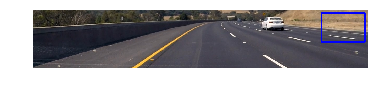

In [24]:
# Test indow_positions() function and print example output
window_positions = def_window_positions(window_positions_y, window_sizes, search_area_x)        
print(window_positions[0])

plot_and_save_test_imgs(test_imgs[2], y_start, y_stop, rectangle = True, 
                        point_1 = window_positions[119][0], point_2 = window_positions[119][1],
                        img_save = True, save_path = "test2.png")

## 2.2 Get features for windows

In [55]:
def assemble_and_resize_windows(img, window_positions, y_start = y_start, y_stop = y_stop,
                                classifier_shape = classifier_shape):
    img = img[y_start:y_stop,:,:]
    window_imgs = []
        
    for position in window_positions:
        tmp_img = img[position[1][1]:position[0][1],position[0][0]:position[1][0],:]
        tmp_img = cv2.resize(tmp_img,dsize=classifier_shape)/255
        window_imgs.append(tmp_img)
        
        
    return np.array(window_imgs)

In [57]:
def make_predictions(imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, classifier_shape):
    # Extract features from all input images (windows)
    feature_vector = extract_features(imgs, orient, pix_per_cell, cell_per_block, hog_channel, 
                                      classifier_shape)
    prediction = svc.predict(feature_vector)
    return prediction

In [59]:
def draw_windows_on_image(img, window_positions, prediction,y_start,y_stop, img_save = False, save_path = None):
    img_plt = img[y_start:y_stop,:,:]
    for position, pred in zip(window_positions,prediction):
        if pred:
            cv2.rectangle(img_plt, position[0], position[1],(0,0,255),6)
    plt.imshow(img_plt)
    plt.axis("off")
    if img_save:
        plt.imsave(save_path,img_plt)

(200, 64, 64, 3)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(200, 64, 64, 3)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  0

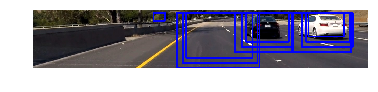

In [124]:
test_imgs_draw = np.copy(test_imgs)
for i,img in enumerate(test_imgs_draw):

    window_imgs = assemble_and_resize_windows(img, window_positions=window_positions)
    print(window_imgs.shape)

    prediction = make_predictions(window_imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                                  classifier_shape)
    print(prediction)


    draw_windows_on_image(img, window_positions,prediction, y_start=y_start, y_stop=y_stop, 
                          img_save = True, save_path = "test{}.png".format(str(i)))

1.0


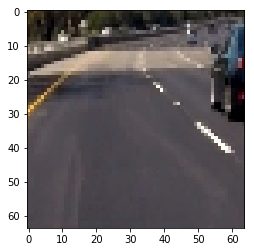

In [117]:
zzz = 31

example = window_imgs[zzz]
print(prediction[zzz])

plt.imshow(example)

In [121]:
print(window_imgs[zzz].shape)
ggg = make_predictions(window_imgs[zzz:zzz+1],svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                       classifier_shape)

print(ggg)

(64, 64, 3)
[ 1.]


In [116]:
print(window_imgs[27])

[[[ 0.16078431  0.16470588  0.04313725]
  [ 0.20392157  0.21176471  0.06666667]
  [ 0.19215686  0.19607843  0.0627451 ]
  ..., 
  [ 0.1372549   0.11764706  0.08627451]
  [ 0.14901961  0.12941176  0.10588235]
  [ 0.10980392  0.09803922  0.07843137]]

 [[ 0.21176471  0.21960784  0.0745098 ]
  [ 0.20784314  0.21568627  0.05882353]
  [ 0.16862745  0.17647059  0.03137255]
  ..., 
  [ 0.22352941  0.20392157  0.18039216]
  [ 0.10588235  0.08627451  0.0627451 ]
  [ 0.09411765  0.08235294  0.05490196]]

 [[ 0.23137255  0.23921569  0.08627451]
  [ 0.21568627  0.22352941  0.06666667]
  [ 0.21960784  0.23529412  0.09019608]
  ..., 
  [ 0.12156863  0.10196078  0.07843137]
  [ 0.18431373  0.15686275  0.13333333]
  [ 0.10196078  0.08627451  0.05098039]]

 ..., 
 [[ 0.41568627  0.37647059  0.36862745]
  [ 0.41176471  0.38431373  0.36078431]
  [ 0.4         0.37254902  0.34901961]
  ..., 
  [ 0.31764706  0.29019608  0.31764706]
  [ 0.2745098   0.25490196  0.27843137]
  [ 0.2745098   0.25490196  0.27843